##### 분류의 성능 평가 지표 : 정확도, 오차행렬, 정밀도, 재현울, F1 스코어, ROC AUC
* 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
 * 직관적으로 모델 예측 성능을 나타내는 평가 지표. 하지만 이진 분류의 겨우 정확도 수치 하나만 가지고 성능을 평가하진 않음
 * 특히 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님
 * → 아무것도 하지 않고 무조건 특정한 결과로 찍어도 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있기 때문

In [211]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# ML 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [212]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit 메서드에선 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    #predict 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        print(X.shape[0])
        pred = np.zeros((X.shape[0],1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [213]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy classifier의 정확도: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

179
Dummy classifier의 정확도: 0.7877


In [214]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    # 입력으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data,y,random_state=11)

In [215]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


##### 오차행렬(혼동행렬) : 이진 분류에서 성능 지표로 잘 활용됨. 
*                     학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표
*                     → 이진 분류의 예측 오류가 얼마인지와 함께 어떠한 유형의 예측 오류가 발생하고 있는지를 보여줌
######                  $ TN |FP \\FN |TP$
* TN : 예측값을 Negative 값 0으로 예측하였고 실제 값 역시 Negative 값 0
* FP : 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
* FN : 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
* TP : 예측값을 Positive 값 1로 예측하였고 실제 값 역시 Positive 값 1
* 이 값들을 조 합하여 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있음
* 정확도 = ${(TN + TP)} \over {(TN + FP + FN + TP)}$

In [216]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

##### 정밀도, 재현율 : Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
* 정밀도(양성 예측도) : TP / (FP + TP)
 *                      예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 
* 재현율(민감도, TPR) : TP / (FN + TP)
 *                      실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율  
* 재현율이 상대적으로 더 중요한 지표인 경우 : 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이
                                             발생하는 경우
* 정밀도가 상대적으로 더 중요한 지표인 경우 : 실제 Negative 음성인 데이터 예측을 Positive 양성 로 잘못 판단하게 되면
                                             업무상 큰 영향이 발생하는 경우

In [217]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'.format(accuracy, precision, recall))

In [218]:
# Logistic Regress 객체 생성 인자로 입력되는 solver = 'liblinear'은 로지스틱 회귀의 최적화 알고리즘 유형을 지정
# liblinear : 작은 데이터 세트의 이진 분류인 경우 약간 성능이 좋은 경향이 있음
# lbfgs : solver의 디폴트, 데이터 세트가 상대적으로 크고 다중 분류인 경우 적합
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=11)
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


In [219]:
# 정밀도/재현율의 트레이드오프 : 한쪽을 강제로 높이면 다른 하나의 수치는 떨어짐
# predict_proba() : 개별 데이터별로 예측 확률을 반환, 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능
#                   테스트 피처 데이터 세트를 파라미터로 입력하면 테스트 피처 레코드의 개별 클래스 예측 확률 반환
# predict : 예측 결과 클래스값, predict_proba : 예측 확률 결과
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


In [220]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]
# X의 개별 원소들이 threshold값보다 길거나 작으면 0, 크면 1
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [221]:
# Binarizer의 threshold 설정값. 분류 결정 임곗값
custom_threshold = 0.5

# predict_proba 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_threshold = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_threshold)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


In [222]:
# Binarizer의 threshold 설정값을 0.4로 설정, 즉 분류 결정 임곗값을 0.4로 낮춤
# 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 됨. 따라서 임곗값을 낮추면 True값이 늘어남
# → Postiive 예측값이 많아지면 상대적으로 재현율 값이 높아짐. 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가
#    상대적으로 줄어들기 때문
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197


In [223]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213


In [224]:
# precision_recall_curve(y_true, probas_pred) : y_true : 실제 클래스값 배열(배열 크기 = [데이터 건수])
#                                               probas_pred : Positive 칼럼의 예측 확률 배열(배열 크기 = [데이터 건수])
#                                               반환 값 - 정밀도 : 임곗값별 정밀도 값을 배열로 반환
#                                                         재현율 : 임곗값별 재현율 값을 배열로 반환
#                                                         임곗값  
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열 로우가 147건이므로, 샘플로 10건만 추출하되 임곗값을 15 Step으로 추출 
thr_index =np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개 : ', thr_index)
print('샘플용 10개의 임곗값 : ',np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도: ', np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율: ', np.round(recalls[thr_index],3))


샘플 추출을 위한 임곗값 배열의 index 10개 :  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 :  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임곗값별 정밀도:  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임곗값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


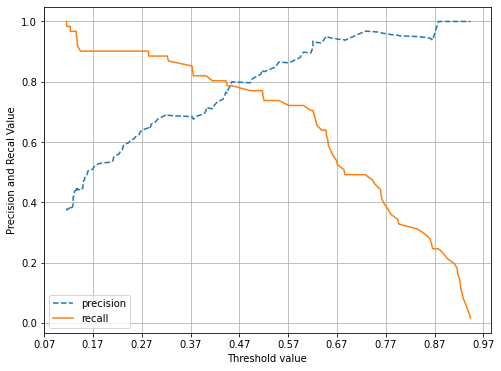

In [225]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축 threshold, Y축 정밀도, 재현율. 정밀도는 점선
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recal Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

###### F1 스코어 
* F1 = ${2*(precision*recall)}\over{precision+recall}$
* 정밀도와 재현율을 결합한 지표
* 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

In [226]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1))

F1 스코어:0.7966


In [227]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pre_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197, F1 : 0.7576
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869, F1 : 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705, F1 : 0.7966
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377, F1 : 0.7965
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213, F1 : 0.8000


### ROC 곡선과 AUC
* ROC 곡선 : FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate, 재현율)이 어떻게 변하는지를 나타내는 곡선  
 * X축 : FPR, Y축 : TPR
 * TNR(True Negative Rate, 특이성) : $TN \over (FP + TN)$,  민감도에 대응하는 지표  
 * 민감도는 실제값 Positive가 정확히 예측돼야 하는 수준을 나타냄  
 * 특이성은 실제값 Negative가 정확이 예측돼야 하는 수준을 나타냄
 * FPR = $FP \over (FP + TN)$ = 1 - TNR = 1 - 특이성
 * ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것, 멀어질수록 성능이 뛰어난 것
 * ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용
 * 분류의 성능 지표로 사용되는 것은 AUC
* AUC(Area Under Curve) : ROC 곡선 밑의 면적을 구한 것, 일반적으로 1에 가까울수록 좋은 수치
 * AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있는지가 관건임
 * 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이되어 면적이 1에 가까워짐
 * 가운데 대각선 직선은 랜덤 수준의 이진 분류 AUC 값으로 0.5 → 보통의 분류는 0.5 이상의 AUC값을 가짐

In [228]:
# roc_curve(y_true, y_score) - y_true : 실제 클래스 값 array (array.shape = [데이터 건수])
#                              y_score : predict_proba의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨 (array.shape = [n_samples])
#                            반환값  fpr : fpr값을 array로 반환
#                                    tpr : tpr값을 array로 반환
#                                    threshold : threshold 값 array

In [229]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# thresholds[0]은 max(예측확률) + 1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index : ', thr_index)
print('샘플 index로 추출한 임곗값 : ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index :  [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값 :  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


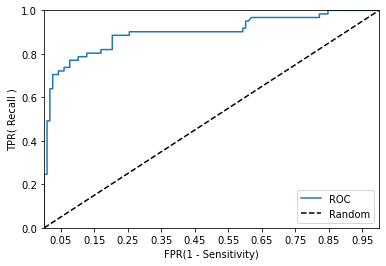

In [230]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선
    plt.plot(fprs, tprs, label='ROC')
    # ROC 곡선에 있는 가운데 직선
    plt.plot([0,1],[0,1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1단위로 변경, X,Y축 명 설정 등
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)');plt.ylabel('TPR( Recall )')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [231]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.8987


In [232]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 피마 인디언 당뇨병 예측

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [234]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [235]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임 → 인덱스 -1로 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727, 정밀도 : 0.7111, 재현율 : 0.5926,     F1 : 0.6465, AUC:0.8083


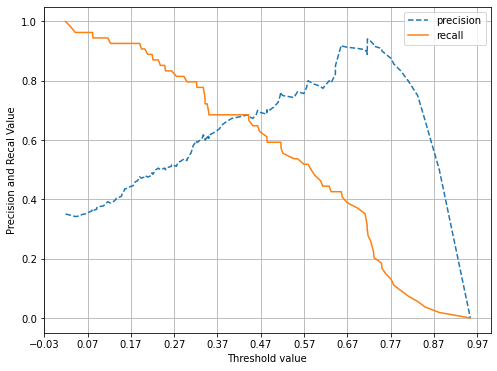

In [236]:
# 전체 데이터의 65%가 Negative이므로 재현율 성능에 초점
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [237]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


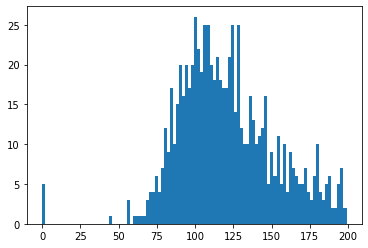

In [238]:
# min이 0인 값이 많음. 예를들어 Glucose(포도당)의 최솟값이 0인건 말이 안됨.
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [239]:
# min이 0인 값을 갖는 피처명 
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 수
total_count = diatbetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수 {1}, 퍼센트 {2:.2f}%'.format(feature, zero_count, 100*zero_count / total_count))

Glucose 0 건수 5, 퍼센트 0.65%
BloodPressure 0 건수 35, 퍼센트 4.56%
SkinThickness 0 건수 227, 퍼센트 29.56%
Insulin 0 건수 374, 퍼센트 48.70%
BMI 0 건수 11, 퍼센트 1.43%


In [240]:
# zero_feature 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [241]:
# 로지스틱 회귀의 경우 일반적으로숫자 데이터에 스케일링을 적용하는 것이 좋음
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:,-1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156,stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred= lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,     F1 : 0.6804, AUC:0.8433


In [243]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [244]:
thresholds=[0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도 : 0.7143, 정밀도 : 0.5658, 재현율 : 0.7963,     F1 : 0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도 : 0.7403, 정밀도 : 0.6000, 재현율 : 0.7778,     F1 : 0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222,     F1 : 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037,     F1 : 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667,     F1 : 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667,     F1 : 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481,     F1 : 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,     F1 : 0.6804, AUC:0.8433


In [245]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

#위에서 구한 lr_clf의 predict_proba 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481,     F1 : 0.6931, AUC:0.8433
